# Poisson equation in a multi-patch domain

In [6]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=100000)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology
from pyiga import assemble_cy

In [7]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 100
kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [8]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(np.pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-np.pi/2).translate((-2, 1))
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

setting up constraints took 0.011377573013305664 seconds.
Basis setup took 0.0041506290435791016 seconds


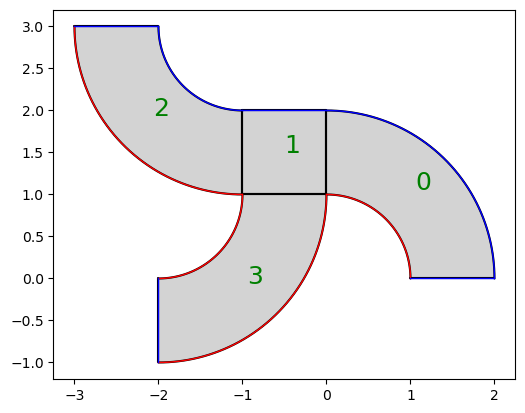

In [9]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: np.exp(-5 * ((x-0.3)**2 + (y-1)**2))
gD = lambda x, y: 1e-1 * np.sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
gN = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Neumann/Robin':{(0,2),(2,3),(3,2),(3,3)},
                   'Dirichlet':{(0,0),(0,3),(1,1),(2,0),(2,2),(3,0)}})

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.draw(patch_idx = True, knots=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

#set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("inner(grad(u), grad(v)) * dx", arity = 2)
Fh = MP.assemble_volume("f * v * dx", arity=1, physical=True, f=f) #f is living in the physical domain

# # generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann/Robin')

# #generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Neumann/Robin')

In [10]:
Kh

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2008597 stored elements and shape (42127, 42127)>

In [11]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

# restrict solution to each individual patch (kvs on every patch) and visualize solution
MP.plot(u, range = (0, 1.5e-1), cmap='viridis')

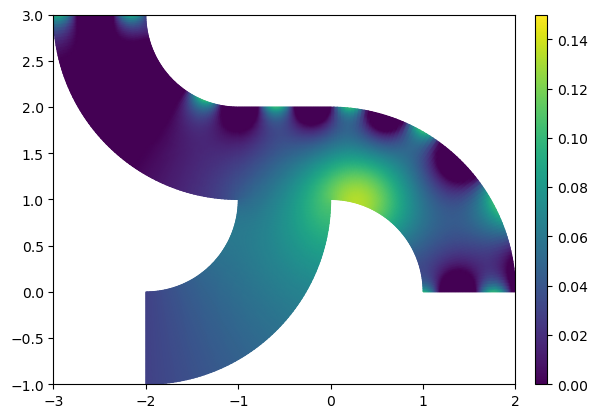

In [12]:
MP.plot(u, range = (0, 1.5e-1), cmap='viridis')

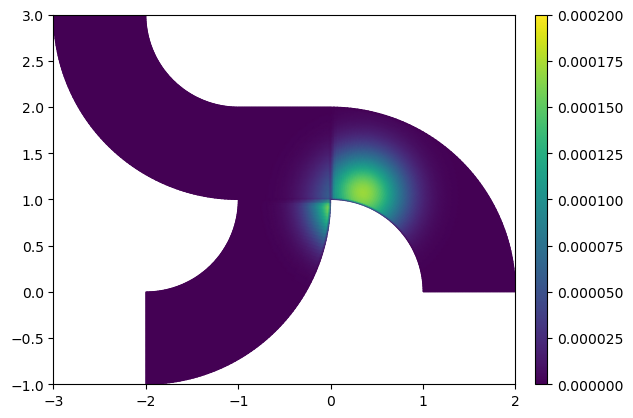

In [16]:
MP.plot(Fh, cmap='viridis')

# Adaptive meshes for singular solutions on a multi-patch domain